# Searchflow

### Packages needed to run this notebook
- libmagic: ```brew install libmagic```


### ChromaDB
Don't forget to start the ChromaDB server: ```docker run -p 8000:8000 chromadb/chroma```

In [1]:
# Load packages from the src directory
import sys
sys.path.append('../src')

from dotenv import load_dotenv
load_dotenv()

from vectrix_graphs import ExtractDocuments, setup_logger, ExtractMetaData

2024-10-22 21:29:39,963 - VectorDB - WARNING - Demo collection already exists
2024-10-22 21:29:40,043 - VectorDB - WARNING - Demo collection already exists


### Extracting chunks of data from a document

In [2]:
# Extract chunks of data from a document
extract = ExtractDocuments(
    logger=setup_logger(name="Files", level="INFO"),
    )

result = extract.extract(file_path="files/attention_is_all_you_need.pdf", )

# Add additional metadata using a NER-pipeline
ner = ExtractMetaData(
    logger=setup_logger(name="ExtractMetaData", level="INFO",),
    model="llama3.1-8B" # Options are gpt-4o-mini, llama3.1-8B , llama3.1-70B
    )
result_with_metadata = ner.extract(result, source="uploaded_file")


2024-10-22 21:29:40,545 - Files - INFO - Extracting documents from files/attention_is_all_you_need.pdf
2024-10-22 21:29:45,567 - ExtractMetaData - INFO - Extracting metadata from 52 documents, using llama3.1-8B


### Adding the documents to a vector database (Chroma)

For this demo, the vector database will be saved locally on disk, restarting the container will delete the database.
I prefer using the cosine distance instead of the default squared L2 distance, we pass this using the `hnsw:space` metadata.

$$
d = 1.0 - \frac{\sum(A_i \times B_i)}{\sqrt{\sum(A_i^2) \cdot \sum(B_i^2)}}
$$

We use Ollama to calculate the embeddings locally with BGE-M3, since over a 100 langues are supported this is ideal for embedding Arabic documents.

BGE-M3 is based on the XLM-RoBERTa architecture and is distinguished for its versatility in Multi-Functionality, Multi-Linguality, and Multi-Granularity:

- Multi-Functionality: It can simultaneously perform the three common retrieval functionalities of embedding model: dense retrieval, multi-vector retrieval, and sparse retrieval.
- Multi-Linguality: It can support more than 100 working languages.
- Multi-Granularity: It is able to process inputs of different granularities, spanning from short sentences to long documents of up to 8192 tokens.

> ℹ️ So all embeddings will be calculated locally ℹ️


In [5]:
from vectrix_graphs import VectorDB
import pathlib
import os

vector_db = VectorDB(logger=setup_logger(name="VectorDB", level="INFO"))

2024-10-22 21:33:01,127 - VectorDB - WARNING - Demo collection already exists


In [7]:
vector_db.add_documents(result_with_metadata)

In [8]:
# Now let's query the vector database
vector_db.similarity_search(
    query="Explain how decoder architecture is used in the paper?",
    k=3
    )

[Document(metadata={'author': '', 'content_type': 'blog_post', 'filename': 'attention_is_all_you_need.pdf', 'filetype': 'application/pdf', 'language': 'EN', 'last_modified': '2024-10-21T15:29:32', 'read_time': 0.59, 'source': 'uploaded_file', 'summary': 'Most competitive neural sequence transduction models have an encoder-decoder structure.', 'tags': "['AI', 'Model Architecture']", 'word_count': 118, 'cosine_distance': 0.3770288509348262}, page_content='3 Model Architecture\n\nMost competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35]. Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive [10], consuming the previously generated symbols as additional input when generating the next.\n\n2\n\nFigure 1: The Transformer -

## Asking questions to the Graph
 Let's now ask questions using the LangGraph workflow

### Example 1: Using closed source LLMs


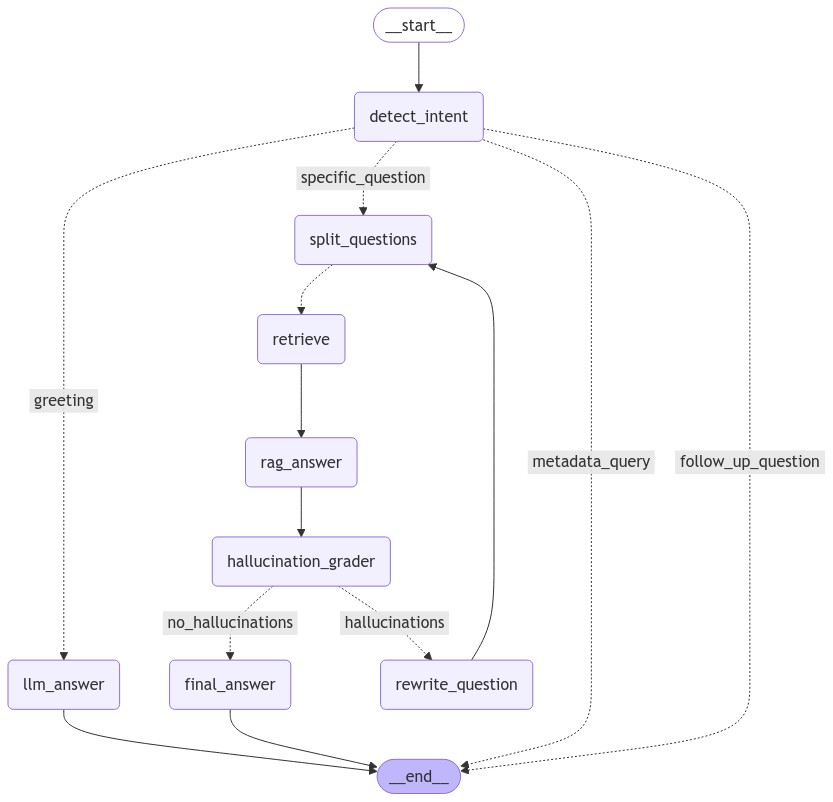

The decoder architecture in the paper is composed of a stack of six identical layers. Each layer in the decoder has three sub-layers. The first two sub-layers are similar to those in the encoder: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network. The third sub-layer in the decoder performs multi-head attention over the output of the encoder stack. 

Additionally, the decoder employs residual connections around each of the sub-layers, followed by layer normalization. A key modification in the decoder's self-attention sub-layer is the use of masking to prevent positions from attending to subsequent positions. This ensures that the prediction for a position can only depend on the known outputs at positions before it. The output embeddings are also offset by one position to maintain this dependency structure.

{'id': '55c3730e-b86b-43d6-9096-338fba9683ef', 'object': 'chat.completion.chunk', 'created': 1729625672, 'model': 'SearchFlow Custom Grap

In [10]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from vectrix_graphs import default_flow
from vectrix_graphs.graphs.utils.stream_processor import StreamProcessor
import warnings

# Display the graph
display(Image(default_flow.get_graph().draw_mermaid_png()))

stream = StreamProcessor(graph=default_flow, logger=setup_logger(name="StreamProcessor", level="INFO"))

# Set the input message
input = [HumanMessage(content="Explain how decoder architecture is used in the paper?")]

# Run the stream and print the chunks
async for chunk in stream.process_stream(messages=input):
    print(chunk)

### Example 2: Using open-source LLMs that can be self-hosted

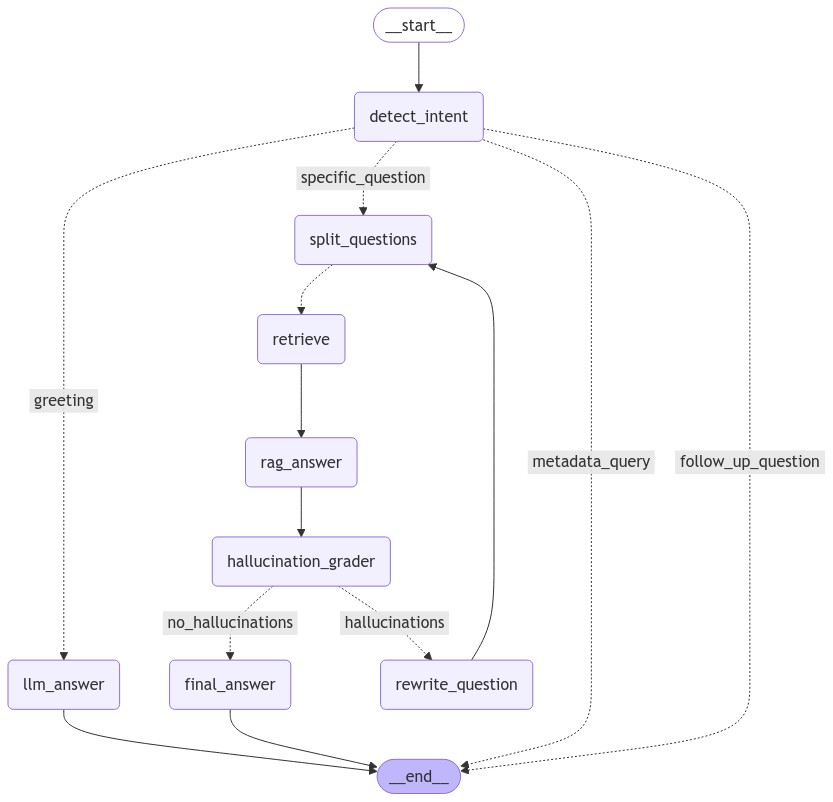

The decoder architecture in the paper is composed of a stack of N = 6 identical layers. Each layer in the decoder has three sub-layers. The first two sub-layers are similar to the encoder, with the first being a multi-head self-attention mechanism and the second being a simple, position-wise fully connected feed-forward network. The third sub-layer is specific to the decoder and performs multi-head attention over the output of the encoder stack.

The decoder also employs residual connections around each of the sub-layers, followed by layer normalization. Additionally, the self-attention sub-layer in the decoder stack is modified to prevent positions from attending to subsequent positions. This is achieved through masking, combined with the fact that the output embeddings are offset by one position. This ensures that the predictions for position i can depend only on the known outputs at positions less than i.

Overall, the decoder architecture is designed to generate an output sequence 

In [11]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from vectrix_graphs import local_slm_demo
from vectrix_graphs.graphs.utils.stream_processor import StreamProcessor

# Display the graph
display(Image(local_slm_demo.get_graph().draw_mermaid_png()))

stream = StreamProcessor(graph=local_slm_demo, logger=setup_logger(name="StreamProcessor", level="INFO"))

# Set the input message
input = [HumanMessage(content="Explain how decoder architecture is used in the paper?")]

# Run the stream and print the chunks
async for chunk in stream.process_stream(messages=input):
    print(chunk)